# Thomas Fermi Approximation 

The Thomas-Fermi Approximation is the limit for a large number of particles in the degenerate regime.

In [167]:
import os


working_directory = "D:/PhD_Trieste/Simulations/Imaging_Simulation"

if os.getcwd()!= working_directory:
    os.chdir(working_directory)  
    
print(working_directory)

import Simulations_Libraries.trajectory_library as trajlib
import numpy as np
import matplotlib.pyplot as plt
from Camera import *
from scipy.stats import poisson
from scipy.optimize import curve_fit
import Simulations_Libraries.general_library as genlib
from tqdm import tqdm
import mpmath as mpm
import matplotlib.cm as cm
from scipy.special import erf

plt.ion()

D:/PhD_Trieste/Simulations/Imaging_Simulation


In [209]:
# System parameters
nOfAtoms = 100
isotope = 171
baseAtom = trajlib.Ytterbium(0,0,0, 0,0,0,isotope=isotope)
initialT = 0.1e-6 # initial temperature



# k = 4
# trapFreqX =np.sqrt((1 + k**4)/2) * 2 * np.pi * 30 
# trapFreqY = 2*np.pi*2.7e3
# trapFreqZ = k * 2*np.pi*2.7e3


trapFreqX = 2 * np.pi * 200
trapFreqY = 2 * np.pi * 200
trapFreqZ = 2 * np.pi * 3e3

planar_lim = 30e-6
discretization = 10

In [210]:
# Needed functions 


def fermi_Energy(omega_Bar,N,gs = 1):
    return trajlib.hbar * omega_Bar * ( 6 * N / gs )**(1/3)

    
def fermi_Temperature(Ef, omegaX,omegaY,omegaZ):
    return (Ef - (0.5 * trajlib.hbar * ( omegaX + omegaY + omegaZ )))/trajlib.kB
    #return Ef/trajlib.kB


def chemical_Potential(T,Ef,Tf,threshold = 0.55):
    
    r = T/Tf
    
    if r >= threshold: # Thermal 
        return trajlib.kB * T * np.log(1/6 * (Tf/T)**3)
        
    elif r< threshold: # Degenerate
        return Ef *( 1- ((np.pi**2)/3) * ( T/Tf)**2)
    

    
def fugacity(T,Ef, Tf):
    mu = chemical_Potential(T = T,Ef = Ef,Tf= Tf)
    return np.exp(mu/T/trajlib.kB)


def TF_Position_Distribution(x,y,z,m,T,Tf,Ef,omegaX,omegaY,omegaZ):
    
    factor1 = - (trajlib.kB * m * T/2/np.pi/trajlib.hbar**2) ** (3/2)
    arg2 = - fugacity(T = T, Ef = Ef, Tf = Tf) * np.exp(- (m/2/trajlib.kB/T) * ((x*omegaX)**2 + (y*omegaY)**2 + (z*omegaZ)**2))
    factor2 =complex(mpm.polylog(3/2,arg2))
    
    return factor1 * factor2


def TF_Momentum_Distribution(x,y,z,m,T,Tf,Ef,omegaX,omegaY,omegaZ):

    omegaBar = (omegaX * omegaY * omegaZ)**(1/3)
    factor1 = - (trajlib.kB * T / 2 / np.pi / m / ((trajlib.hbar * omegaBar)**2))**(3/2)
    
    arg2 = - fugacity(T = T, Ef = Ef, Tf = Tf) * np.exp(- (p**2) / (2*m*trajlib.kB*T) )
    factor2 = complex(mpm.polylog(3/2,arg2))
    
    return factor1 *factor2

def ThG_Position_Distribution(x,y,z, mu, sigmaX,sigmaY,sigmaZ):
    
    gx =  (1 / (sigmaX * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu[0]) / sigmaX)**2)  
    gy =  (1 / (sigmaY * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((y - mu[1]) / sigmaY)**2)  
    gz =  (1 / (sigmaZ * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((z - mu[2]) / sigmaZ)**2)  
    
    return  gx * gy * gz      
    

In [211]:
# Thermal Gas Parameters 

n_0X = trajlib.n_T(trapFreqX,initialT)
n_0Y = trajlib.n_T(trapFreqY,initialT)
n_0Z = trajlib.n_T(trapFreqZ,initialT)

x_rms = np.sqrt(trajlib.hbar/(2*baseAtom.m*trapFreqX)*(2*n_0X+1))
y_rms = np.sqrt(trajlib.hbar/(2*baseAtom.m*trapFreqY)*(2*n_0Y+1))
z_rms = np.sqrt(trajlib.hbar/(2*baseAtom.m*trapFreqZ)*(2*n_0Z+1))
    
v_x_rms = np.sqrt(trajlib.hbar*trapFreqX/(2*baseAtom.m)*(2*n_0X+1))
v_y_rms = np.sqrt(trajlib.hbar*trapFreqY/(2*baseAtom.m)*(2*n_0Y+1))
v_z_rms = np.sqrt(trajlib.hbar*trapFreqZ/(2*baseAtom.m)*(2*n_0Z+1))

atomPositions = []
atomVelocities = []
for i in range(nOfAtoms):
        
    atomPositions.append(np.random.normal(0, [x_rms, y_rms, z_rms], size=(3)))
    atomVelocities.append(np.random.normal(0, [v_x_rms, v_y_rms, v_z_rms], size=(3)))
			
atomPositions = np.asarray(atomPositions)
atomVelocities = np.asarray(atomVelocities)


x = np.linspace(-planar_lim,planar_lim,discretization)
posDistrThGX = ThG_Position_Distribution(x= x, y = 0, z = 0, mu = [0,0,0], sigmaX = x_rms, sigmaY= y_rms, sigmaZ = z_rms)
posDistrThGX_scaled = nOfAtoms*posDistrThGX * 1e-18
posDistrThGX_norm = posDistrThGX/np.max(posDistrThGX) 


y = np.linspace(-planar_lim,planar_lim,discretization)
posDistrThGY = ThG_Position_Distribution(x= 0, y = y, z = 0, mu = [0,0,0], sigmaX = x_rms, sigmaY= y_rms, sigmaZ = z_rms)
posDIstrThGY_scaled = nOfAtoms*posDistrThGY * 1e-18
posDistrThGY_norm = posDistrThGY/np.max(posDistrThGY) 

z = np.linspace(-5*z_rms,5*z_rms,discretization)
posDistrThGZ = ThG_Position_Distribution(x= 0, y = 0, z = z, mu = [0,0,0], sigmaX = x_rms, sigmaY= y_rms, sigmaZ = z_rms)
posDIstrThGZ_scaled = nOfAtoms*posDistrThGZ * 1e-18
posDistrThGZ_norm = posDistrThGZ/np.max(posDistrThGZ) 


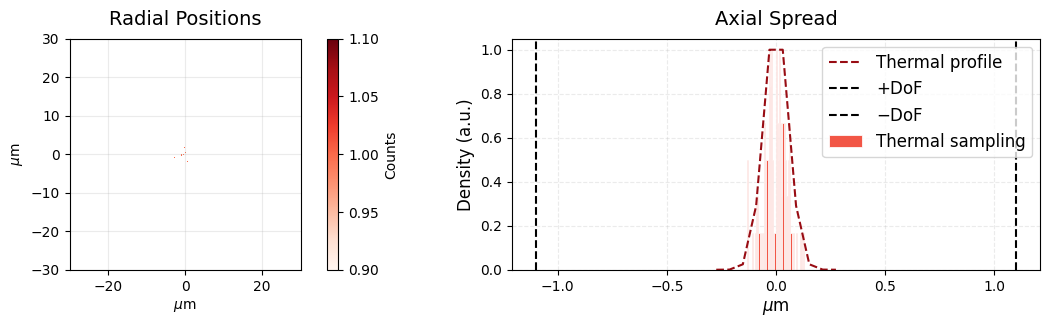

In [212]:
# Thermal Gas Plots
planarLim = planar_lim
DoF = 1.1
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

#axes[0].set_xticks([])
#axes[0].set_yticks([])


h = axes[0].hist2d(
    atomPositions[:, 0] * 1e6,
    atomPositions[:, 1] * 1e6,
    bins=100,              # adjust resolution
    cmap=cm.Reds,
    cmin=1                 # hide empty bins (optional)
)
plt.colorbar(h[3], ax=axes[0], label="Counts")


axes[0].set_xlim(-planarLim*1e6,planarLim*1e6)
axes[0].set_ylim(-planarLim*1e6,planarLim*1e6)
axes[0].set_xlabel(r'$\mu$m')
axes[0].set_ylabel(r'$\mu$m')
axes[0].set_title(f'Radial Positions',fontsize=14, pad=10)
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.25)
    
# axes[1].hist(
#     atomPositions[:,2]*1e6,
#     bins=100,
#     density=True,
#     color=cm.Reds(0.6),
#     edgecolor='white',
#     linewidth=0.6,
#     alpha=0.9
# )

# Normalized histogram 
counts, bin_edges = np.histogram(atomPositions[:,2]*1e6, bins=50, density=False)

bin_width = bin_edges[1] - bin_edges[0]
hist_norm = counts / np.max(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot histogram on axes[1]
axes[1].bar(
    bin_centers,
    hist_norm,
    width=bin_width,
    color=cm.Reds(0.6),
    edgecolor='white',
    linewidth=0.6,
    alpha=0.9,
    label='Thermal sampling'
)

# Plot normalized theory
axes[1].plot(
    z*1e6,
    posDistrThGZ_norm,   # This should already be area-normalized
    color=cm.Reds(0.9),
    linestyle='--',
    linewidth=1.5,
    label='Thermal profile'
)



axes[1].set_xlabel(r'$\mu$m', fontsize=12)
axes[1].set_ylabel('Density (a.u.)', fontsize=12)
axes[1].set_title('Axial Spread', fontsize=14, pad=10)

axes[1].axvline(+DoF, color='black', linestyle='--', linewidth=1.5, label=r'$+\mathrm{DoF}$')
axes[1].axvline(-DoF, color='black', linestyle='--', linewidth=1.5, label=r'$-\mathrm{DoF}$')


# Clean up appearance
axes[1].grid(True, which='major', alpha=0.25, linestyle='--')
axes[1].set_axisbelow(True)
axes[1].legend(fontsize = 12)


In [213]:
# Thomas Fermi Computations
trapFreqBar = (trapFreqX*trapFreqY*trapFreqZ) ** (1/3)

fermiEn = fermi_Energy(omega_Bar = trapFreqBar, N = nOfAtoms)
fermiTemp = fermi_Temperature(Ef = fermiEn, omegaX = trapFreqX, omegaY = trapFreqY, omegaZ = trapFreqZ)

posDistrTFX = []
for i in range(len(x)):
    posDistrTFX.append(TF_Position_Distribution(
            x = x[i],
            y = 0,
            z = 0,
            m = baseAtom.m,
            T = initialT,
            Tf = fermiTemp,
            Ef = fermiEn,
            omegaX = trapFreqX,
            omegaY = trapFreqY,
            omegaZ = trapFreqZ
            ))
posDistrTFX = np.asarray(posDistrTFX)    
posDistrTFX_scaled = posDistrTFX * 1e-18
posDistrTFX_norm = posDistrTFX/np.max(posDistrTFX) 

posDistrTFY = []
for i in range(len(y)):
    posDistrTFY.append( TF_Position_Distribution(
            x = 0,
            y = y[i],
            z = 0,
            m = baseAtom.m,
            T = initialT,
            Tf = fermiTemp,
            Ef = fermiEn,
            omegaX = trapFreqX,
            omegaY = trapFreqY,
            omegaZ = trapFreqZ
            ))
posDistrTFY = np.asarray(posDistrTFY)
posDistrTFY_scaled = posDistrTFY * 1e-18
posDistrTFY_norm = posDistrTFY/np.max(posDistrTFY)

posDistrTFZ = []
for i in range(len(z)):
    posDistrTFZ.append(TF_Position_Distribution(
            x = 0,
            y = 0,
            z = z[i],
            m = baseAtom.m,
            T = initialT,
            Tf = fermiTemp,
            Ef = fermiEn,
            omegaX = trapFreqX,
            omegaY = trapFreqY,
            omegaZ = trapFreqZ
            )) 
posDistrTFZ = np.asarray(posDistrTFZ)
posDistrTFZ_scaled = posDistrTFZ * 1e-18
posDistrTFZ_norm = posDistrTFZ/np.max(posDistrTFZ)


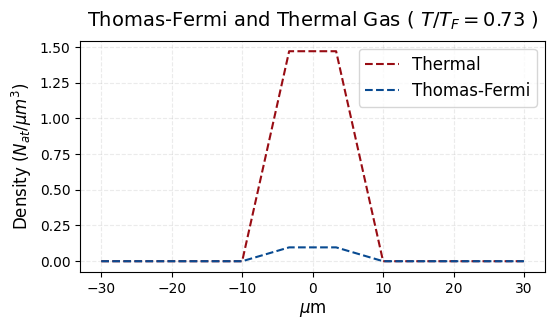

In [214]:
# Distribution spreads comparison 


plt.figure(figsize = (6,3))


plt.plot(x*1e6,posDistrThGX_scaled,color=cm.Reds(0.9), linestyle='--', linewidth=1.5, label='Thermal')
plt.plot(x*1e6,posDistrTFX_scaled,color=cm.Blues(0.9), linestyle='--', linewidth=1.5, label='Thomas-Fermi')


plt.xlabel(r'$\mu$m', fontsize=12)
plt.ylabel('Density ($N_{at}/\mu m^3$)', fontsize=12)
plt.title(rf'Thomas-Fermi and Thermal Gas ( $T/T_F = {np.round(initialT/fermiTemp,2)}$ )', fontsize=14, pad=10)


# Clean up appearance
plt.grid(True, which='major', alpha=0.25, linestyle='--')
plt.legend(fontsize = 12)


In [215]:
# Planar density of the two distributions

# Thermal Gas 
posDistrThGPlanar = []
for i in tqdm(range(len(y)), desc="ThG Iterations",mininterval=1,maxinterval=30):
    posDistrThGPlanar.append(ThG_Position_Distribution(x= x, y = y[i], z = 0, mu = [0,0,0], sigmaX = x_rms, sigmaY= y_rms, sigmaZ = z_rms))
posDistrThGPlanar = np.asarray(posDistrThGPlanar)


# Thomas Fermi 
posDistrTFPlanar = []
for i in tqdm(range(len(x)), desc="TF Iterations",mininterval=1,maxinterval=30):
    line = []
    for j in range(len(y)):
        line.append(TF_Position_Distribution(
            x = x[i],
            y = y[j],
            z = 0,
            m = baseAtom.m,
            T = initialT,
            Tf = fermiTemp,
            Ef = fermiEn,
            omegaX = trapFreqX,
            omegaY = trapFreqY,
            omegaZ = trapFreqZ
            ))
    posDistrTFPlanar.append(line)
    
posDistrTFPlanar = np.asarray(posDistrTFPlanar)              


TF Iterations: 100%|█████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1987.07it/s]


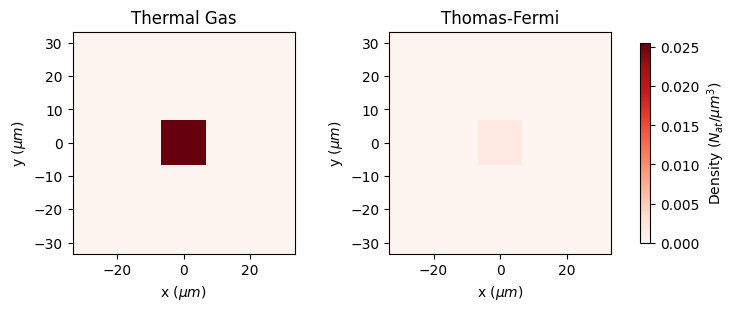

In [216]:

X, Y = np.meshgrid(x, y)

# Use the real part since that's what you're plotting
A = nOfAtoms* posDistrThGPlanar*1e-18
B = np.real(posDistrTFPlanar) * 1e-18

# Global color scale (you can tweak vmin if you want symmetry)
vmin = 0
vmax = max(np.nanmax(A), np.nanmax(B))

fig, axes = plt.subplots(1, 2, figsize=(7.5, 3), constrained_layout=True)

pcm1 = axes[0].pcolormesh(X*1e6, Y*1e6, A, shading='auto', vmin=vmin, vmax=vmax,cmap='Reds')
axes[0].set_title('Thermal Gas')
axes[0].set_xlabel('x ($\mu m$)')
axes[0].set_ylabel('y ($\mu m$)')
axes[0].set_aspect('equal')

pcm2 = axes[1].pcolormesh(X*1e6, Y*1e6, B, shading='auto', vmin=vmin, vmax=vmax,cmap='Reds')
axes[1].set_title('Thomas-Fermi')
axes[1].set_xlabel('x ($\mu m$)')
axes[1].set_ylabel('y ($\mu m$)')
axes[1].set_aspect('equal')

# One shared colorbar
cbar = fig.colorbar(pcm1, ax=axes, shrink=0.9)
cbar.set_label('Density ($N_{at}/\mu m^3$)')

plt.show()

In [217]:
# # Integral Check

# deltaZ = (z[1] - z[0])*1
# deltaPlanar = (x[1]-x[0]) * (y[1]-y[0])

# thermalInt = erf(deltaZ/2/np.sqrt(2)/z_rms)*nOfAtoms # integral of the thermal distribution 
# TFInt = np.sum(posDistrTFPlanar)*deltaZ * deltaPlanar
# print('Thermal: ',np.round(thermalInt))
# print('TF: ',np.round(np.real(TFInt))) # assoming the distribution enough smooth in the center 


In [218]:
# Just a check 

# trapFreqX = 2*np.pi*100
# trapFreqY = 2*np.pi*100
# trapFreqZ = 2*np.pi*400

# trapFreqBar = (trapFreqX*trapFreqY*trapFreqZ)**(1/3)
# nOfAtoms = 1e5

# fermiEn = fermi_Energy(omega_Bar = trapFreqBar, N = nOfAtoms)
# fermiTemp = fermi_Temperature(Ef = fermiEn, omegaX = trapFreqX, omegaY = trapFreqY, omegaZ = trapFreqZ)

# temp = np.array([0.02,0.05, 0.1,0.15,0.2,0.4,1])*fermiTemp

# z = fugacity(T = temp,Ef = fermiEn, Tf = fermiTemp)
# print(z,fermiTemp*1e9)


# Mean Interparticle Spacing for different Atom Number and Temperatures

In [219]:

nOfAtoms = np.arange(100,1001,1)

thermalGasPeakDensity = nOfAtoms*ThG_Position_Distribution(x= 0, y = 0, z = 0, mu = [0,0,0], sigmaX = x_rms, sigmaY= y_rms, sigmaZ = z_rms) 
ThGMinInterparticleSpacing = thermalGasPeakDensity**(-1/3)

TFPeakDensity = []
fermiTemperatures = []
for i in range(len(nOfAtoms)):
    
    fermiEn = fermi_Energy(omega_Bar = trapFreqBar, N = nOfAtoms[i])
    fermiTemp = fermi_Temperature(Ef = fermiEn, omegaX = trapFreqX, omegaY = trapFreqY, omegaZ = trapFreqZ)
    fermiTemperatures.append(fermiTemp)
    
    TFPeakDensity.append(TF_Position_Distribution(
            x = 0,
            y = 0,
            z = 0,
            m = baseAtom.m,
            T = initialT,
            Tf = fermiTemp,
            Ef = fermiEn,
            omegaX = trapFreqX,
            omegaY = trapFreqY,
            omegaZ = trapFreqZ
            ))
TFPeakDensity = np.asarray(TFPeakDensity)    
TFMinInterparticleSpacing = TFPeakDensity**(-1/3)


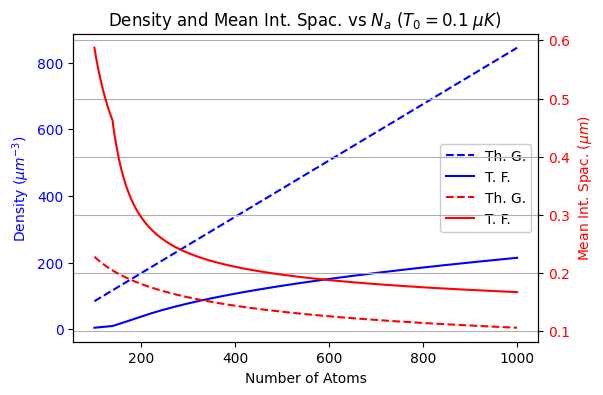

In [220]:
fig, ax1 = plt.subplots(figsize=(6,4))

# Plot density on left y-axis
ax1.plot(nOfAtoms, thermalGasPeakDensity * 1e-18,color = 'b',ls = '--', label = 'Th. G.')
ax1.plot(nOfAtoms, TFPeakDensity * 1e-18,color = 'b',label = 'T. F.')
ax1.set_xlabel('Number of Atoms')
ax1.set_ylabel('Density ($\mu m^{-3}$)', color='b')
ax1.tick_params(axis='y', labelcolor='b')


# Create right y-axis for mean interparticle spacing
ax2 = ax1.twinx()
ax2.plot(nOfAtoms, ThGMinInterparticleSpacing*1e6,color = 'r',ls = '--',label = 'Th. G.')
ax2.plot(nOfAtoms, TFMinInterparticleSpacing*1e6,color = 'r',label = 'T. F.')
ax2.set_ylabel('Mean Int. Spac. ($\mu m$)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
#ax2.hlines(opticalResolution*1e6,0,np.max(nOfAtoms),ls = '--', color = 'r', label = 'Optical Resolution')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', framealpha=1)


plt.title(f'Density and Mean Int. Spac. vs $N_a$ ($T_0 = {np.round(initialT*1e6,2)}$ $\mu K$) ')

plt.grid(True)
plt.show()

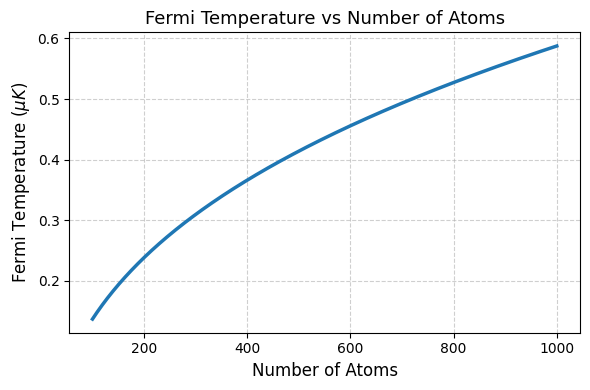

In [221]:
plt.figure(figsize=(6,4))

plt.plot(
    nOfAtoms,
    np.array(fermiTemperatures)*1e6,
    color='tab:blue',
    linewidth=2.5
)

plt.xlabel('Number of Atoms', fontsize=12)
plt.ylabel('Fermi Temperature ($\mu K$)', fontsize=12)
plt.title('Fermi Temperature vs Number of Atoms', fontsize=13)

plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()
